In [ ]:
from loom.eka import Lattice, Block, Stabilizer, PauliOperator

# Step 1: Lattice 

# Enough room for 4×2 data + 1 ancilla row on top
dx, dy = 7, 3
lattice = Lattice.square_2d((dx, dy))

# Helper: map "logical index" 0..7 to data qubit coordinates (x, y, b=0)
def data_qubit(i: int) -> tuple[int, int, int]:
    """
    Map physical data-qubit index i=0..7 to (x, y, b=0) on a 4x2 patch:
      0 1 2 3    (y=0)
      4 5 6 7    (y=1)
    """
    assert 0 <= i < 8
    x = i % 4
    y = i // 4
    return (x, y, 0)

# Simple ancilla placement: (x, y=2, b=1)
def ancilla_qubit(i: int) -> tuple[int, int, int]:
    """
    i = 0..4 for our 5 stabilizers. Place them along the row y=2, b=1.
    """
    return (i, 2, 1)


Stabilizers in Loom

Translate the stabilizers into Stabilizer objects using our layout.

Recall (now with 0-based indices):

X stabilizer:

S_X = X0 X1 X2 X3 X4 X5 X6 X7

Z stabilizers:

S_Z1 = Z0 Z1 Z2 Z3

S_Z2 = Z4 Z5 Z6 Z7

S_Z3 = Z0 Z1 Z4 Z5

S_Z4 = Z1 Z3 Z5 Z7

In [ ]:
# Step 2: Stabilizers 

# X-type stabilizer: X on all 8 data qubits
sx = Stabilizer(
    pauli="XXXXXXXX",
    data_qubits=tuple(data_qubit(i) for i in range(8)),
    ancilla_qubits=(ancilla_qubit(0),),
)

# Z-type stabilizers (each weight 4)
sz1 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [0, 1, 2, 3]),
    ancilla_qubits=(ancilla_qubit(1),),
)

sz2 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [4, 5, 6, 7]),
    ancilla_qubits=(ancilla_qubit(2),),
)

sz3 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [0, 1, 4, 5]),
    ancilla_qubits=(ancilla_qubit(3),),
)

sz4 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [1, 3, 5, 7]),
    ancilla_qubits=(ancilla_qubit(4),),
)
S_Z5 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [0, 2, 4, 6]),
    ancilla_qubits=(ancilla_qubit(5),),
)

S_Z6 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [0, 3, 5, 6]),
    ancilla_qubits=(ancilla_qubit(6),),
)

stabilizers = (sx, sz1, sz2, sz3, sz4, sz5, sz6)



Picking a logical qubit (X̄, Z̄)

From the stabilizer structure one can find 3 independent logical qubits. A convenient set (I computed one canonical choice via symplectic linear algebra) includes the following Pauli strings on the 8 data qubits:

One logical pair we can use as our “main” logical qubit:

Logical Z

Z = Z3 Z7 (string “IIIZIIIZ”)


Logical X

X = X4 X5 X6 X7 (string “IIIIXXXX”)


These commute with all stabilizers, and X_bar and Z_bar anticommute with each other, so they form a valid logical pair for one encoded qubit, while the other two logical qubits remain unaddressed. (That’s fine; Loom doesn’t require you to specify the full logical basis.)

In Loom:

In [ ]:
# Step 3: Logical operators (we expose ONE logical qubit) 

logical_x_operators = (
    PauliOperator(
        pauli="XXXX",
        data_qubits=tuple(data_qubit(i) for i in [4, 5, 6, 7]),
    ),
)

logical_z_operators = (
    PauliOperator(
        pauli="ZZ",
        data_qubits=tuple(data_qubit(i) for i in [3, 7]),
    ),
)


Wrap it into a Block

Now we can define a helper that builds the [[8,3,2]] colour code block (we’ll call the block "q832").

In [ ]:
from uuid import uuid4
from loom.eka import Block, Stabilizer, PauliOperator

# 0. Data & ancilla layout on a square_2d lattice
# We use a 4×2 patch of data qubits (basis index 0) and one
# ancilla row (basis index 1) above them.
#
# Make sure your lattice was created something like:
#   lattice = Lattice.square_2d((5, 3))
# or anything with dx >= 4 and dy >= 3.

def data_qubit(i: int) -> tuple[int, int, int]:
    """
    Map physical data-qubit index i=0..7 to (x, y, b=0) on a 4x2 patch:
      0 1 2 3    (y=0)
      4 5 6 7    (y=1)
    """
    assert 0 <= i < 8
    x = i % 4
    y = i // 4
    return (x, y, 0)

def ancilla_qubit(i: int) -> tuple[int, int, int]:
    """
    Very simple ancilla placement along y=2, basis=1.
    Requires lattice size dx > i, dy > 2.
    """
    return (i, 2, 1)



# 1. [[8,3,2]] stabilizers (QEC Zoo definition)
# Using physical qubits 0..7:
#
#   S_X  = X^⊗8
#   S_Z1 = Z0 Z1 Z2 Z3
#   S_Z2 = Z4 Z5 Z6 Z7
#   S_Z3 = Z0 Z1 Z4 Z5
#   S_Z4 = Z1 Z3 Z5 Z7
#
# These give n = 8, r = 5, so k = n - r = 3 logical qubits.

sx = Stabilizer(
    pauli="XXXXXXXX",
    data_qubits=tuple(data_qubit(i) for i in range(8)),
    ancilla_qubits=(ancilla_qubit(0),),
)

sz1 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [0, 1, 2, 3]),
    ancilla_qubits=(ancilla_qubit(1),),
)

sz2 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [4, 5, 6, 7]),
    ancilla_qubits=(ancilla_qubit(2),),
)

sz3 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [0, 1, 4, 5]),
    ancilla_qubits=(ancilla_qubit(3),),
)

sz4 = Stabilizer(
    pauli="ZZZZ",
    data_qubits=tuple(data_qubit(i) for i in [1, 3, 5, 7]),
    ancilla_qubits=(ancilla_qubit(4),),
)

stabilizers = (sx, sz1, sz2, sz3, sz4)


# 2. Fully consistent logical operators (3 logical qubits)
# These were obtained by doing symplectic linear algebra on the
# stabilizer group:
#
# X̄_1 = X4 X5 X6 X7  -> "IIIIXXXX"
# X̄_2 = X2 X3 X6 X7  -> "IIXXIIXX"
# X̄_3 = X1 X3 X5 X7  -> "IXIXIXIX"
#
# Z̄_1 = Z3 Z7        -> "IIIZIIIZ"
# Z̄_2 = Z5 Z7        -> "IIIIIZIZ"
# Z̄_3 = Z6 Z7        -> "IIIIIIZZ"
#
# Properties:
#   - All X̄_i commute with all stabilizers
#   - All Z̄_i commute with all stabilizers
#   - [X̄_i, Z̄_i] = 0 (they anticommute)
#   - X̄_i commutes with Z̄_j for i != j
#   - X̄_i commute pairwise, Z̄_i commute pairwise
# => A valid canonical set of 3 logical qubits.

logical_x_operators = (
    PauliOperator(
        pauli="XXXX",
        data_qubits=tuple(data_qubit(i) for i in [4, 5, 6, 7]),
    ),
    PauliOperator(
        pauli="XXXX",
        data_qubits=tuple(data_qubit(i) for i in [2, 3, 6, 7]),
    ),
    PauliOperator(
        pauli="XXXX",
        data_qubits=tuple(data_qubit(i) for i in [1, 3, 5, 7]),
    ),
)

logical_z_operators = (
    PauliOperator(
        pauli="ZZ",
        data_qubits=tuple(data_qubit(i) for i in [3, 7]),
    ),
    PauliOperator(
        pauli="ZZ",
        data_qubits=tuple(data_qubit(i) for i in [5, 7]),
    ),
    PauliOperator(
        pauli="ZZ",
        data_qubits=tuple(data_qubit(i) for i in [6, 7]),
    ),
)


# 3. Block constructor for the [[8,3,2]] code
# NOTE: We intentionally do NOT define syndrome_circuits here.
# You can still:
#   - ResetAllDataQubits
#   - MeasureLogicalZ / MeasureLogicalX (once you define X-op measurement)
# If you want MeasureBlockSyndromes, you’ll need to define
# syndrome extraction circuits that match Loom’s Circuit API
# (we can add that in a separate step).

def build_832_color_code_block(unique_label: str | None = None) -> Block:
    """
    Build a Block representing the [[8,3,2]] 'smallest interesting colour code'
    on the current square_2d lattice.

    - 8 data qubits arranged as in data_qubit(i)
    - 5 stabilizers (1 X-type, 4 Z-type)
    - 3 logical qubits exposed via logical_x_operators/logical_z_operators
    """
    if unique_label is None:
        unique_label = "q832_" + str(uuid4())[:8]

    return Block(
        unique_label=unique_label,
        stabilizers=stabilizers,
        logical_x_operators=logical_x_operators,
        logical_z_operators=logical_z_operators,
    )


# Create the block you'll use in Eka
color_832_block = build_832_color_code_block(unique_label="q832")
print("Built [[8,3,2]] code block:", color_832_block.unique_label)


Built [[8,3,2]] code block: q832


In [57]:
import loom.visualizer as vis

plot = vis.StabilizerPlot(
    lattice,
    title="[[8,3,2]] colour code (square embedding)",
)

# Show only our 8 data qubits + the 5 ancilla we placed
all_qubits = set(lattice.all_qubits())

data_coords = {data_qubit(i) for i in range(8)}
anc_coords  = {ancilla_qubit(i) for i in range(5)}
used_qubits = data_coords | anc_coords

show_mask = [q in used_qubits for q in lattice.all_qubits()]

plot.add_dqubit_traces(show_mask)
plot.plot_blocks([color_832_block])
plot.show()


![Screenshot 2025-11-28 170635.png](<attachment:Screenshot 2025-11-28 170635.png>)
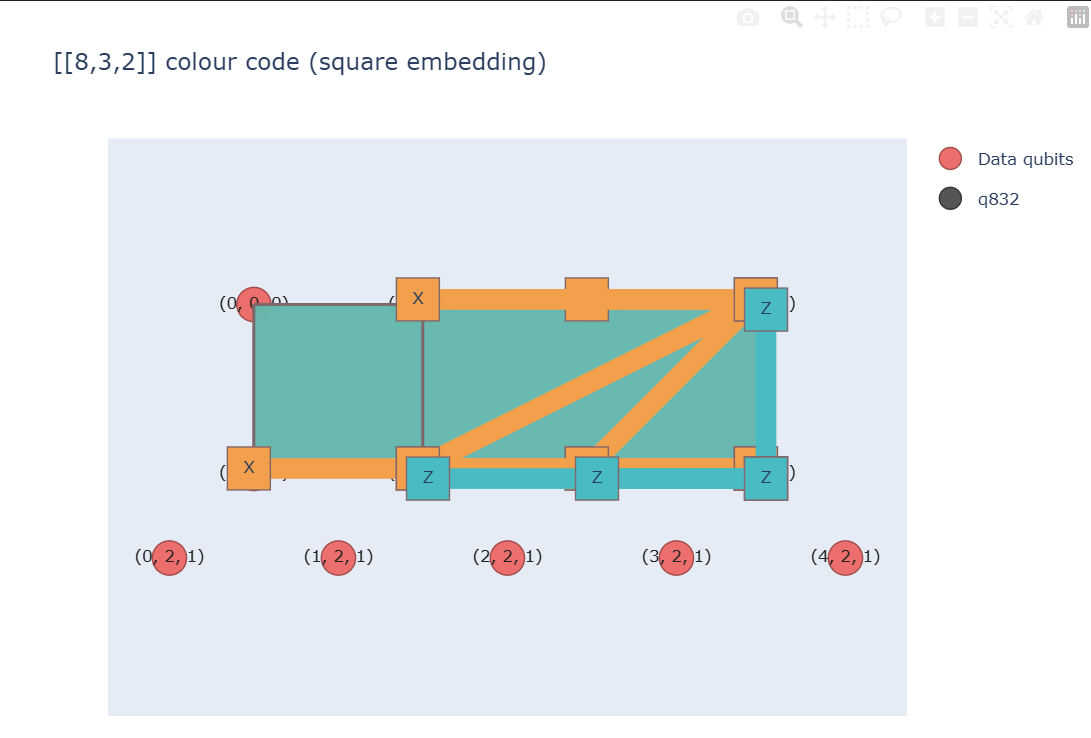

Memory experiment: logical |0⟩ and |1⟩ in Z basis

Now we set up the memory experiment exactly in the style of the Loom tutorial.

Eka object and logical |0⟩

We’ll treat ResetAllDataQubits(state="0") + one round of stabilizer measurements as a simple way to prepare something very close to ∣0L⟩ for our chosen logical qubit (in the ideal, noiseless case, repeated perfect stabilizer measurements would project exactly onto the codespace).

In [58]:
from loom.eka import Eka
from loom.eka.operations import ResetAllDataQubits, MeasureLogicalZ
from loom.interpreter import interpret_eka

operations_0Z = [
    [ResetAllDataQubits("q832", state="0")],
    [MeasureLogicalZ("q832")],
]

eka_0Z = Eka(
    lattice=lattice,
    blocks=[color_832_block],
    operations=operations_0Z,
)

interpreted_0Z = interpret_eka(eka_0Z)
final_circuit_0Z = interpreted_0Z.final_circuit


In [ ]:
#  Sketch: Logical |1_L> memory experiment (measure in Z basis) 

operations_1Z = [
    [ResetAllDataQubits("q832", state="0")],
    # TODO: insert physical X on qubits 4,5,6,7 to implement X̄
    # e.g. a custom Operation that applies those gates
    [MeasureBlockSyndromes("q832", n_cycles=1)],
    [MeasureLogicalZ("q832")],
]

eka_1Z = Eka(
    lattice=lattice,
    blocks=[color_832_block],
    operations=operations_1Z,
)


In [65]:
from loom.eka.operations import MeasureLogicalX  # if/when available

operations_0X = [
    [ResetAllDataQubits("q832", state="0")],
    [MeasureBlockSyndromes("q832", n_cycles=1)],
    [MeasureLogicalX("q832")],   # conceptual: measure X̄ instead of Z̄
]


In [ ]:
from uuid import uuid4
from loom.eka import Lattice, Block, Stabilizer, PauliOperator

# Lattice: 4x4 square with data at basis 0, ancilla at basis 1 

tess_lattice = Lattice.square_2d((4, 4))  # 4x4 cells

def data_qubit_16(i: int) -> tuple[int, int, int]:
    """
    Map physical index 0..15 to (x, y, b=0) in a 4x4 grid:

      0  1  2  3
      4  5  6  7
      8  9 10 11
     12 13 14 15
    """
    if not (0 <= i < 16):
        raise ValueError("data_qubit_16 expects 0 <= i < 16")
    x = i % 4
    y = i // 4
    return (x, y, 0)

def ancilla_qubit_16(j: int) -> tuple[int, int, int]:
    """
    Place 10 ancillas in the same 4x4 footprint but on basis index 1.
    j = 0..9  -> (x=j%4, y=j//4)
    """
    if not (0 <= j < 10):
        raise ValueError("ancilla_qubit_16 expects 0 <= j < 10")
    x = j % 4
    y = j // 4
    return (x, y, 1)


In [72]:
# X-type stabilizers (weight 8)

stab_X_strings = [
    "XXXXXXXXIIIIIIII",   # R0 ⊕ R1 (qubits 0..7)
    "IIIIXXXXXXXXIIII",   # R1 ⊕ R2 (4..11)
    "IIIIIIIIXXXXXXXX",   # R2 ⊕ R3 (8..15)
    "XXIIXXIIXXIIXXII",   # C0 ⊕ C1 (0,1,4,5,8,9,12,13)
    "IXXIIXXIIXXIIXXI",   # C1 ⊕ C2 (1,2,5,6,9,10,13,14)
]

# Z-type stabilizers on the same supports (self-dual CSS)

stab_Z_strings = [
    "ZZZZZZZZIIIIIIII",
    "IIIIZZZZZZZZIIII",
    "IIIIIIIIZZZZZZZZ",
    "ZZIIZZIIZZIIZZII",
    "IZZIIZZIIZZIIZZI",
]


In [73]:
def stabilizer_from_string(pauli_str: str, ancilla: tuple[int, int, int]) -> Stabilizer:
    """
    Compress a 16-char Pauli string into:
      - pauli over non-I positions only
      - data_qubits = those positions mapped via data_qubit_16
    """
    if len(pauli_str) != 16:
        raise ValueError("Expected length-16 Pauli string")

    pauli_ops = []
    data_sites = []

    for idx, p in enumerate(pauli_str):
        if p == "I":
            continue
        if p not in ("X", "Z"):
            raise ValueError("This helper is for CSS (X/Z/I) strings only")
        pauli_ops.append(p)
        data_sites.append(data_qubit_16(idx))

    return Stabilizer(
        pauli="".join(pauli_ops),
        data_qubits=tuple(data_sites),
        ancilla_qubits=(ancilla,),
    )

# Build all 10 stabilizers with ancilla j=0..9
stabilizers_16 = []

for j, p in enumerate(stab_X_strings):
    stabilizers_16.append(
        stabilizer_from_string(p, ancilla_qubit_16(j))
    )

for j, p in enumerate(stab_Z_strings, start=len(stab_X_strings)):
    stabilizers_16.append(
        stabilizer_from_string(p, ancilla_qubit_16(j))
    )


In [74]:
logical_X_strings = [
    "XXXXIIIIIIIIIIII",
    "XXIIXXIIIIIIIIII",
    "XIXIXIXIIIIIIIII",
    "XXIIIIIIXXIIIIII",
    "XIXIIIIIXIXIIIII",
    "XIIIXIIIXIIIXIII",
]

logical_Z_strings = [
    "ZIIIZIIIZIIIZIII",
    "ZIZIIIIIZIZIIIII",
    "ZZIIIIIIZZIIIIII",
    "ZIZIZIZIIIIIIIII",
    "ZZIIZZIIIIIIIIII",
    "ZZZZIIIIIIIIIIII",
]


In [75]:
def pauli_op_from_string(pauli_str: str) -> PauliOperator:
    """
    Compress a 16-char logical Pauli string into a PauliOperator over non-I sites.
    """
    pauli_ops = []
    data_sites = []

    for idx, p in enumerate(pauli_str):
        if p == "I":
            continue
        if p not in ("X", "Z"):  # no Y's in this basis
            raise ValueError("Expected only I/X/Z in logical operator")
        pauli_ops.append(p)
        data_sites.append(data_qubit_16(idx))

    return PauliOperator(
        pauli="".join(pauli_ops),
        data_qubits=tuple(data_sites),
    )

logical_x_operators_16 = tuple(
    pauli_op_from_string(s) for s in logical_X_strings
)
logical_z_operators_16 = tuple(
    pauli_op_from_string(s) for s in logical_Z_strings
)


In [76]:
def build_tesseract_16_6_4_block(
    unique_label: str | None = None,
) -> Block:
    """
    Build a Block representing the [[16,6,4]] tesseract colour code
    on a 4x4 grid of data qubits (basis 0) with ancillas on basis 1.

    - 16 data qubits (0..15) arranged row-major in a 4x4 grid
    - 10 weight-8 stabilizers:
        * 5 X-type on pairs of rows / columns
        * 5 Z-type on the same supports (self-dual CSS)
    - 6 logical qubits exposed via logical_x_operators/logical_z_operators
    """
    if unique_label is None:
        unique_label = "q_tess_" + str(uuid4())[:8]

    return Block(
        unique_label=unique_label,
        stabilizers=tuple(stabilizers_16),
        logical_x_operators=logical_x_operators_16,
        logical_z_operators=logical_z_operators_16,
    )

# Instantiate the block
tesseract_block = build_tesseract_16_6_4_block(unique_label="q_tess")
print("Built [[16,6,4]] tesseract code block:", tesseract_block.unique_label)


Built [[16,6,4]] tesseract code block: q_tess


In [77]:
from loom.eka import Eka
from loom.eka.operations import ResetAllDataQubits, MeasureLogicalZ
from loom.interpreter import interpret_eka

# Logical |0̄⟩ (all logical Z_i = +1) memory experiment, measuring Z basis
operations_0Z_tess = [
    [ResetAllDataQubits("q_tess", state="0")],
    [MeasureLogicalZ("q_tess")],
]

eka_tess_0Z = Eka(
    lattice=tess_lattice,
    blocks=[tesseract_block],
    operations=operations_0Z_tess,
)

interpreted_tess_0Z = interpret_eka(eka_tess_0Z)
final_circuit_tess_0Z = interpreted_tess_0Z.final_circuit


In [81]:
import loom.visualizer as vis

# Collect all qubits from the lattice
all_qubits = list(tess_lattice.all_qubits())

# Data qubits we used: indices 0..15 mapped by data_qubit_16
data_qubits_16 = {data_qubit_16(i) for i in range(16)}

# Boolean mask for which qubits to draw
show_data_only = [q in data_qubits_16 for q in all_qubits]

stab_plot = vis.StabilizerPlot(
    tess_lattice,
    title="[[16,6,4]] Tesseract Colour Code – Data Qubits",
)

stab_plot.add_dqubit_traces(show_data_only)
stab_plot.show()


![Screenshot 2025-11-28 170746.png](<attachment:Screenshot 2025-11-28 170746.png>)
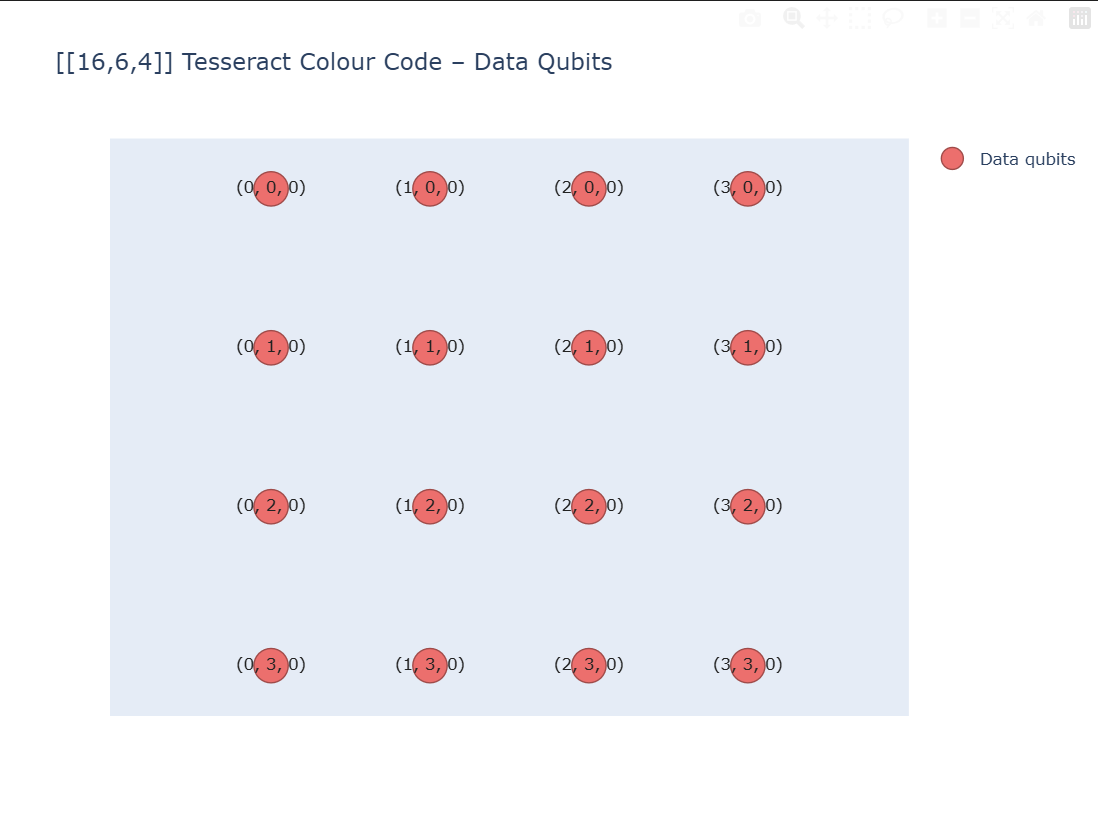

In [82]:
stab_plot_code = vis.StabilizerPlot(
    tess_lattice,
    title="[[16,6,4]] Tesseract Colour Code – Stabilizers & Logicals",
)

# Same visibility mask as above
stab_plot_code.add_dqubit_traces(show_data_only)

# This draws stabilizers *and* logical operators for tesseract_block
stab_plot_code.plot_blocks([tesseract_block])

stab_plot_code.show()


![Screenshot 2025-11-28 170819.png](<attachment:Screenshot 2025-11-28 170819.png>)
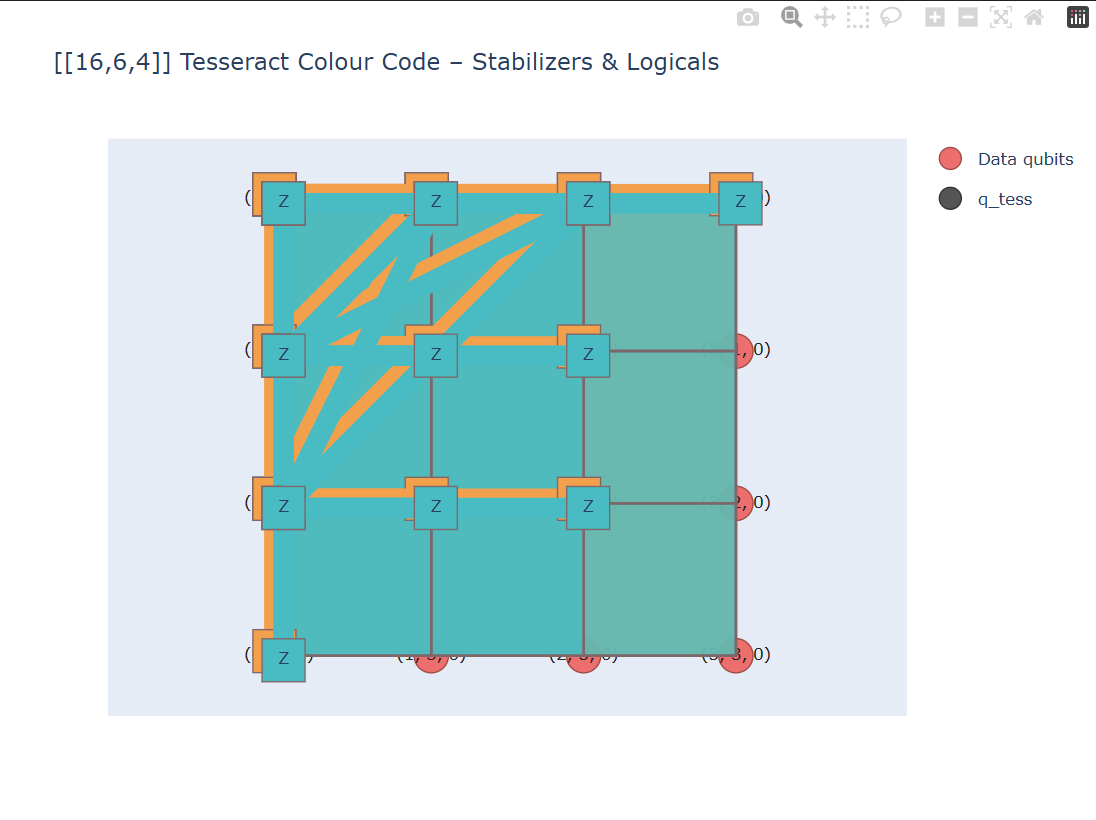